# **Deep Hedging**
# Buchkov Viacheslav

In [1]:
from pathlib import Path

from deep_hedging import ExperimentConfig, EuropeanCall, seed_everything
from deep_hedging.dl import SpotDataset, Trainer, Assessor
from deep_hedging.dl.models import LSTMHedger

RANDOM_SEED = 12

In [2]:
config = ExperimentConfig(
    RANDOM_SEED=RANDOM_SEED,
    DATA_ROOT=Path("data")
)
seed_everything(RANDOM_SEED)

config.DEVICE

device(type='mps')

In [3]:
config

ExperimentConfig(N_DAYS=5, REBAL_FREQ='30 min', VAR_QUANTILE=0.05, TEST_SIZE=0.1, RANDOM_SEED=12, DATA_ROOT=PosixPath('data'), DATA_FILENAME='data_full', NORMALIZE=False, USE_TIME_DIFF=True, USE_SPOT_START=True, N_EPOCHS=20, LR=0.01, BATCH_SIZE=32, NUM_LAYERS=3, HIDDEN_DIM=32, OPTIMIZER=<class 'torch.optim.adam.Adam'>, NUM_WORKERS=2)

## Dataset.

In [4]:
spot_dataset = SpotDataset(
    n_days=config.N_DAYS,
    instrument_cls=EuropeanCall
)
spot_dataset.df.head()

,bid,ask,rub_rate,usd_rate,time_diff
timestamp,,,,,
2017-01-03 07:00:00+00:00,60.973760,61.016500,0.081265,0.00672,0.000000
2017-01-03 07:01:00+00:00,61.010855,61.068045,0.081265,0.00672,0.000002
2017-01-03 07:02:00+00:00,61.037220,61.069850,0.081265,0.00672,0.000004
2017-01-03 07:03:00+00:00,61.011955,61.048690,0.081265,0.00672,0.000006
2017-01-03 07:04:00+00:00,61.021250,61.052835,0.081265,0.00672,0.000008


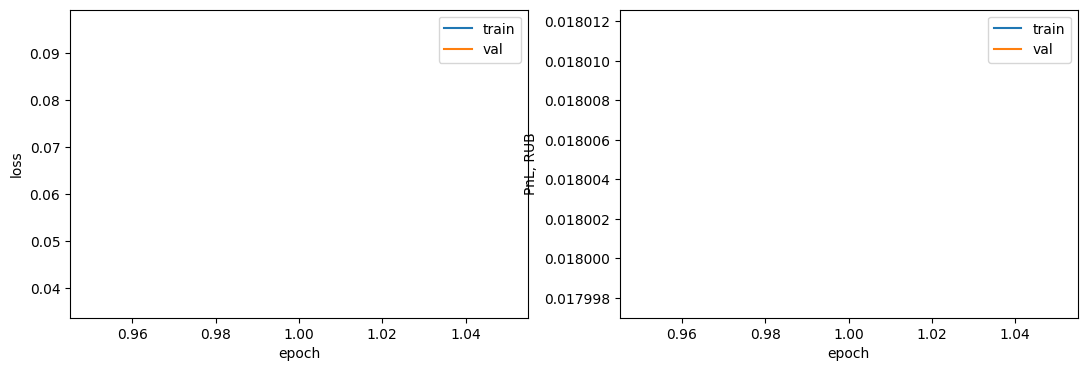

([0.09631233074772462],
 [0.03664491746860064],
 [array([[-0.08141121, -0.08615933, -0.08884778, ..., -0.09200848,
          -0.09200848, -0.09200848],
         [-0.08141357, -0.08615662, -0.08883764, ..., -0.09194596,
          -0.09194597, -0.09194616],
         [-0.08141264, -0.08615698, -0.0888392 , ..., -0.09187816,
          -0.09187817, -0.09187818],
         ...,
         [-0.08141257, -0.08615732, -0.0888401 , ..., -0.0919549 ,
          -0.09195491, -0.0919549 ],
         [-0.08140973, -0.08616006, -0.08885087, ..., -0.0919091 ,
          -0.09190911, -0.0919091 ],
         [-0.08141208, -0.08615825, -0.08884311, ..., -0.09184867,
          -0.09184867, -0.09184868]], dtype=float32),
  array([[-0.0814099 , -0.08615968, -0.08884913, ..., -0.09216952,
          -0.09216953, -0.09216954],
         [-0.08141247, -0.08615696, -0.08883911, ..., -0.09185207,
          -0.09185208, -0.09185208],
         [-0.08141463, -0.08613914, -0.08880186, ..., -0.09165632,
          -0.09165688,

In [5]:
trainer = Trainer(
    model_cls=LSTMHedger,
    instrument_cls=EuropeanCall,
    config=config
)
trainer.run(1)

In [ ]:
class BaselineForward(nn.Module):
    def __init__(self, dt: float = AVERAGE_DT):
        super().__init__()

        self.lstm = nn.LSTM(1, 1, num_layers=1, batch_first=True)
        self.dt = dt

    def forward(self, spot: torch.Tensor, return_hidden: bool = False) -> torch.Tensor:
        return torch.Tensor([[1] * (spot.shape[1] - 2)] * spot.shape[0]).to(torch.float32).to(DEVICE)

    def get_pnl(self, spot: torch.Tensor) -> torch.float32:
        # hedging_weights = nn.Softmax()(self.linear(spot, return_hidden=False), dim=XXX)
        hedging_weights = self.forward(spot, return_hidden=False)
        return hedging_weights, get_pnl(spot=spot, weights=hedging_weights, dt=self.dt)

In [ ]:
assess_model(hedger, BaselineForward().to(DEVICE))

In [ ]:
assess_model(hedger, BaselineForward().to(DEVICE))

## Option.

In [ ]:
import numpy as np


class EuropeanCall(Instrument):
    def __init__(
            self,
            rates_difference: float,
            spot_price: float,
            term: float
    ):
        super().__init__()
        self.rates_difference = rates_difference
        self.spot_price = spot_price
        self.term = term

    def coupon(self, frequency: float = 0., *args, **kwargs) -> float:
        return 0

    def pv_coupons(self) -> float:
        return 0

    def get_strike(self, spot_price: [float, None] = None) -> float:
        return self.spot_price

    @property
    def strike(self) -> float:
        return self.get_strike()

    def price(self, spot_start: [float, list[float], None] = None) -> float:
        return 0

    def payoff(self, spot: [float, np.array]) -> float:
        return max(spot - self.strike, 0)

    def __repr__(self):
        return f"EuropeanCall(strike={self.strike}, term={self.term}, spot_ref={self.spot_price})"

In [ ]:
class BaselineEuropeanCall(nn.Module):
    def __init__(self, dt: float = AVERAGE_DT):
        super().__init__()

        self.lstm = nn.LSTM(1, 1, num_layers=1, batch_first=True)
        self.dt = dt

        self.strike = 1

    def _call_delta(self, mid: torch.Tensor, rates: torch.Tensor, terms: torch.Tensor) -> torch.float32:
        """
        Call non_linear delta [dV/dS] via analytical form solution of Black-Scholes-Merton.

        Returns
        -------
        delta : float
            Option delta.
        """
        strikes = mid[:, 0] * self.strike
        # print(strikes[: -1])
        sigma = mid.std(dim=1).unsqueeze(1)
        # print("***")
        d1 = (torch.log(mid / strikes.unsqueeze(1)) + (rates + sigma ** 2 / 2) * terms) / (sigma * torch.sqrt(terms))
        d1 = d1[:, 1:-1]
        # print(d1.shape)
        # print("***")

        cdf_d1 = torch.distributions.normal.Normal(0, 1).cdf(d1)

        return cdf_d1

    def forward(self, spot: torch.Tensor, return_hidden: bool = False) -> torch.Tensor:
        mid = (spot[:, :, 0] + spot[:, :, 1]) / 2
        rates = spot[:, :, 2] - spot[:, :, 3]
        terms = spot[:, :, 4]
        return self._call_delta(mid=mid, rates=rates, terms=terms)

    def get_pnl(self, spot: torch.Tensor) -> torch.float32:
        # hedging_weights = nn.Softmax()(self.linear(spot, return_hidden=False), dim=XXX)
        hedging_weights = self.forward(spot, return_hidden=False)
        return hedging_weights, get_pnl(spot=spot, weights=hedging_weights, dt=self.dt)

In [ ]:
baseline = BaselineEuropeanCall().to(DEVICE)
loader = DataLoader(spot_dataset, batch_size=32, shuffle=True, drop_last=True)
for feature, target in loader:
    print(feature.shape)
    w = baseline(feature)
    pnl = baseline.get_pnl(feature.to(torch.float32))
    break
w

In [ ]:
w.shape

In [ ]:
w[:, -1]

In [ ]:
feature[:, -1, :2]

In [ ]:
feature[0]

In [ ]:
class NeuralHedger(nn.Module):
    def __init__(self, input_size: int = 5, num_layers: int = 3, hidden_size: int = 32, dt: float = AVERAGE_DT):
        super().__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.dt = dt

        self.batch_norm = nn.BatchNorm1d(241)

        self.lstm = nn.LSTM(input_size, self.hidden_size, num_layers=num_layers, batch_first=True)

        self.hedging_weights = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )

    def forward(self, spot: torch.Tensor, hidden: [(torch.Tensor), None] = None, return_hidden: bool = False) -> [
        torch.Tensor,
        (torch.Tensor, torch.Tensor, torch.Tensor)]:
        model_device = spot.device
        if hidden is None:
            h_t = torch.zeros(self.num_layers, spot.size(0), self.hidden_size, dtype=torch.float32).to(model_device)
            c_t = torch.zeros(self.num_layers, spot.size(0), self.hidden_size, dtype=torch.float32).to(model_device)
        elif len(hidden) != 2:
            raise ValueError(f"Expected two hidden state variables, got {len(hidden)}")
        else:
            h_t, c_t = hidden

        price = self.batch_norm(spot[:, :, :2])
        rates = self.batch_norm(spot[:, :, 2:4])
        spot = torch.cat([price, rates, spot[:, :, 4:]], dim=2)

        h_t, c_t = self.lstm(spot, (h_t, c_t))
        outputs = self.hedging_weights(h_t)[:, 1:-1, :].squeeze(2)

        if return_hidden:
            return outputs, (h_t, c_t)
        else:
            return outputs

    def get_pnl(self, spot: torch.Tensor) -> [torch.Tensor, torch.float32]:
        # hedging_weights = nn.Softmax()(self.linear(spot, return_hidden=False), dim=XXX)
        weights = self.forward(spot, return_hidden=False)

        model_device = spot.device
        weights_all = torch.concat([torch.zeros(spot.shape[0], 1, requires_grad=False).to(model_device), weights,
                                    torch.zeros(spot.shape[0], 1, requires_grad=False).to(model_device)], dim=1)
        weights_diff = weights_all.diff(n=1, dim=1)

        rates_diff = spot[:, :, 2] - spot[:, :, 3]

        bought = torch.where(weights_diff > 0, weights_diff, 0)
        sold = torch.where(weights_diff < 0, weights_diff, 0)

        interest = (rates_diff * -weights_all).sum(dim=1) * self.dt

        cash_outflow = (-spot[:, 1:, 1] * bought).sum(dim=1)
        cash_inflow = (-spot[:, 1:, 0] * sold).sum(dim=1)

        pnl = (cash_outflow + cash_inflow + interest).unsqueeze(1)

        return weights, pnl

In [ ]:
call_hedger = NeuralHedger().to(DEVICE)
loader = DataLoader(SpotDataset(data=train_df, instrument_cls=EuropeanCall), batch_size=32, shuffle=True, drop_last=False)
for feature, target in loader:
    print(feature.shape)
    w = call_hedger(feature.to(DEVICE))
    pnl = call_hedger.get_pnl(feature.to(torch.float32).to(DEVICE))
    break
w

In [ ]:
hedger = NeuralHedger()
loader = DataLoader(SpotDataset(data=train_df, instrument_cls=EuropeanCall), batch_size=32, shuffle=True, drop_last=False)

for feature, target in loader:
    print(feature.shape)
    pnl = hedger.get_pnl(feature.to(torch.float32))
    break
pnl

In [ ]:
N_EPOCHS = 30

hedger = NeuralHedger().to(DEVICE)

train_set = SpotDataset(data=train_df, instrument_cls=EuropeanCall)
val_set = SpotDataset(data=test_df, instrument_cls=EuropeanCall)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=False)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, drop_last=False)

# optimizer = torch.optim.SGD(hedger.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(hedger.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)

train_losses, val_losses, weights, train_diffs, val_diffs = train(
    model=hedger,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=N_EPOCHS,
    print_logs=True
)

In [ ]:
torch.save(hedger, PATH / "opt_out_new_30_bn.pt")

In [ ]:
assess_model(hedger, BaselineEuropeanCall().to(DEVICE))

In [ ]:
assess_model(hedger, BaselineEuropeanCall().to(DEVICE))